# SCADAA Report

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.integrate import odeint, solve_ivp, quad
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from exercise2 import DGM_Layer, Net_DGM
from exercise2 import FFN


## Exercise 1.1

In [2]:
class LQR:
    def __init__(self, H, M, sigma, C, D, R, T) -> None:
        self.H = H 
        self.M = M
        self.sigma = sigma
        self.C = C 
        self.D = D 
        self.R = R
        self.T = T
    

    def riccati_ode(self, t, S_flat):
        S = torch.tensor(S_flat, dtype=torch.float32).reshape((2, 2))  # Convert S_flat to a PyTorch tensor
        dS = (-2 * (self.H.t() @ S) + S @ (self.M) @ (torch.inverse(self.D)) @ (np.transpose(self.M)) @ S - self.C)
        return dS.flatten().detach().numpy()
 

    def solve_ricatti_ode(self, time_grid):
        """
        Solves the LQR problem by integrating the 
        Riccati equation backwards in time.
        """
        # Time points (reversed for backward integration)
        # t_points = np.linspace(0, self.T, 1000)[::-1]  
        intial_cond = self.R.flatten().detach().numpy()

        sol = solve_ivp(
            self.riccati_ode, [self.T.item(), time_grid[0].item()], 
            intial_cond, t_eval=time_grid.numpy()[::-1], method='RK45'
            )
        
        S = torch.tensor(sol.y)

        return S

    def visualize_results(self, t_points, S):
        """
        Visualizes the solution of the Riccati equation 
        or the state/control trajectories.
        """
        # S_00 = [s[0, 0].item() for s in S]
        plt.plot(t_points, S[0, :])
        plt.xlabel('Time')
        plt.ylabel('S[0,0]')
        plt.title('Solution of Riccati Equation over Time')
        plt.show()
       

    def markov_control(self, t_batch, x_batch):
        a=torch.tensor([])
        for t in range(len(t_batch)):
            time_grid = torch.linspace(float(t_batch[t]), self.T, 1000, dtype=torch.float32)
            S = self.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float()
            S_ordered =torch.flip(S,dims=[0])
            x_batch_n = x_batch[t]
            a_ = -((torch.inverse(self.D.float()) @ self.M.T) @ S_ordered[0]) @ x_batch_n.T
            a=torch.cat((a,a_.unsqueeze(0))) 
        return a.transpose(1,2)


    def value_function(self, t_batch, x_batch):
        v=torch.tensor([])
        for t in range(len(t_batch)):
            time_grid = torch.linspace(float(t_batch[t]), self.T, 1000, dtype=torch.float32)
            S = self.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float()
            S_ordered =torch.flip(S,dims=[0])
            sigma = self.sigma
            x_batch_n = x_batch[t]

            # Compute the first term: x.transpose(S)x
            x_S_x = torch.matmul(torch.matmul(x_batch_n.unsqueeze(0), S_ordered[0]), x_batch_n.unsqueeze(0).transpose(-1, -2)).squeeze()

        # Compute the integral term using Einstein summation notation with smaller time steps
            integral_term = 0
            for i in range(len(time_grid) - 1):
                dt = time_grid[i + 1] - time_grid[i]
                int_term=sigma@sigma.T@S_ordered[i]
                trace_term = torch.einsum('bij->b',int_term.unsqueeze(0))
                integral_term += trace_term * dt

            # Compute the total value function: v(t, x) = x.transpose(S)x + trace_term
            v=torch.cat((v,x_S_x + integral_term)) 
        return v


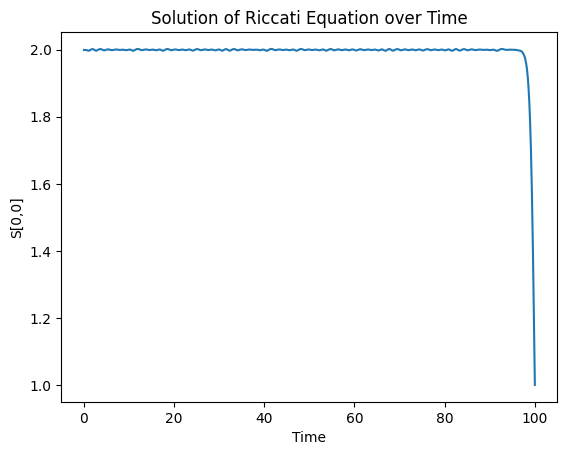

Optimal Markov Control:
tensor([[[-1.9989, -3.9979]],

        [[-1.9980,  0.0000]],

        [[-5.9926, -3.9950]]])
Value Function:
tensor([406.6639, 397.4678, 420.6382])


In [3]:
# Example Usage:
# Define problem matrices
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
C = torch.tensor([[0, 0], [0, 0]], dtype=torch.float32)
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(100, dtype=torch.float32)

# Initialize LQRController
# controller = LQRController(H, M, D, C, R, T)

# Define time grid
time_grid = torch.linspace(0, T, 10000)

lqr_system = LQR(H, M, sigma, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid)
S_sol_v2 = S_solution.T.reshape(len(time_grid),2,2)
S_sol_ordered =torch.flip(S_sol_v2,dims=[0])
lqr_system.visualize_results(torch.flip(time_grid, [0]), S_solution)

# Create sample input tensors
t_batch = torch.tensor([0.5, 0.8, 1.0], dtype=torch.float32)  # Sample time values
x_batch = torch.tensor([
    [[1.0, 2.0]],  
    [[1.0, 0.0]], 
    [[3.0, 2.0]]  
], dtype=torch.float32)  # Sample spatial values

# t_batch = torch.tensor([0.7], dtype=torch.float32)  # Sample time values
# x_batch = torch.tensor([
#     [[1.0, 1.0]] 
# ], dtype=torch.float32)  # Sample spatial values

# Compute the markov control
markov_control = lqr_system.markov_control(t_batch, x_batch)

# Print the computed value function
print("Optimal Markov Control:")
print(markov_control)

# Compute the value function
value_func = lqr_system.value_function(t_batch, x_batch)

# Print the computed value function
print("Value Function:")
print(value_func)



In [4]:
t_batch.shape, x_batch.shape

(torch.Size([3]), torch.Size([3, 1, 2]))

## Exercise 1.2

1. Error

2. Time

In [22]:
#Create error function 
def calculate_error(X):
    #We might want to have a better error function tbh
    error = np.linalg.norm(X - np.zeros(X.shape))
    return error

In [36]:

#Initial Conditions
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.1
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.001
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(1.0, dtype=torch.float32)
x0 = torch.tensor([1, 1], dtype=torch.float32)
t=torch.tensor(0.7, dtype=torch.float32)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*10


# Define time grid
time_grid_S = torch.linspace(0, T, 10000)
lqr_system = LQR(H, M, sigma, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid_S)
S_sol_v2 = S_solution.T.reshape(len(time_grid_S),2,2).float()
S_sol_ordered =torch.flip(S_sol_v2,dims=[0])


In [37]:
# X Generation
def generate_x(T, N_steps, H, M, D, S_solution, sigma, x0):

    x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1) 
    tau = T / N_steps
    X = x0.unsqueeze(0)
    brownian = torch.randn(N_steps, 2, dtype=torch.float32)*torch.sqrt(tau)

    for i in range(N_steps-1):
        dw = (brownian[i+1] - brownian[i]).view(2, 1)  # Ensure dw is a 2x1 vector
        # Calculate control action, ensuring it results in a 2x1 vector
        a_s = -torch.inverse(D) @ M.T @ S_sol_ordered[i] @ X[-1]
        # Update state, ensuring result is a 2x1 vector
        next_val = X[-1] + tau * (H @ X[-1] + M @ a_s) + sigma @ dw  # Use matrix-vector product for sigma @ dw
        
        X=torch.cat((X,next_val.view(2, 1).unsqueeze(0))) # Ensure next_val remains a 2x1 column vector

    return X.transpose(1,2)

# Call the function with corrected inputs
N_steps = 100
result = generate_x(T, N_steps, H.float(), M.float(), D.float(), S_solution.float(), sigma.float(), x0)
print(result)

tensor([[[1.0000, 1.0000]],

        [[0.9907, 0.9907]],

        [[0.9816, 0.9816]],

        [[0.9727, 0.9728]],

        [[0.9636, 0.9640]],

        [[0.9549, 0.9548]],

        [[0.9461, 0.9462]],

        [[0.9376, 0.9376]],

        [[0.9288, 0.9289]],

        [[0.9206, 0.9206]],

        [[0.9120, 0.9120]],

        [[0.9037, 0.9037]],

        [[0.8954, 0.8955]],

        [[0.8872, 0.8871]],

        [[0.8792, 0.8791]],

        [[0.8712, 0.8709]],

        [[0.8631, 0.8629]],

        [[0.8552, 0.8550]],

        [[0.8474, 0.8472]],

        [[0.8394, 0.8393]],

        [[0.8319, 0.8318]],

        [[0.8243, 0.8243]],

        [[0.8167, 0.8166]],

        [[0.8091, 0.8091]],

        [[0.8017, 0.8019]],

        [[0.7945, 0.7945]],

        [[0.7870, 0.7871]],

        [[0.7799, 0.7799]],

        [[0.7728, 0.7728]],

        [[0.7657, 0.7658]],

        [[0.7586, 0.7585]],

        [[0.7517, 0.7518]],

        [[0.7446, 0.7450]],

        [[0.7380, 0.7381]],

        [[0.73

/tmp/ipykernel_3056/2947327018.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


### Exercise 1.2.1

The error will be the difference between between the cost function and the value function, and this should converge for bigger time steps.

### Exercise 1.2.2

In [38]:
# 1.2.2 CODE DO NOT RUN IN GITHUB IF USING N_SAMPLES=100000

N_samples=100 #CHANGE FOR LOCAL RUNNING
N_steps=[1, 10, 50, 100, 500, 1000, 5000]
cost=torch.tensor([])
S_sol_cs = CubicSpline(time_grid_S, S_sol_ordered)
exp_cost=torch.tensor([])
for t in range(len(N_steps)):
    time_grid = torch.linspace(0, T, N_steps[t]+1)
    dt= time_grid[1:]-time_grid[:-1]
    S_sol_cs_vals = torch.tensor((S_sol_cs(time_grid.numpy())),dtype=torch.float32)
    for i in range(N_samples):
        result = generate_x(T, N_steps[t]+1, H.float(), M.float(), D.float(), 
                            S_sol_cs_vals.float(), sigma.float(), x0)
        alp = (-torch.inverse(D) @ M.T @ S_sol_cs_vals @result.transpose(1,2)).transpose(1,2)
        int_ = result@C@result.transpose(1,2) + alp@D@alp.transpose(1,2)
        J = torch.tensor(0.5)*dt@((int_.squeeze(1)[1:]+int_.squeeze(1)[:-1]))
        cost=torch.cat((cost,J))
    exp_cost=torch.cat((exp_cost,torch.mean(cost).unsqueeze(0)))

/tmp/ipykernel_3056/2947327018.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


tensor([25.2738, 12.7254,  8.3078,  6.0846,  4.7263,  3.8009,  2.9942])


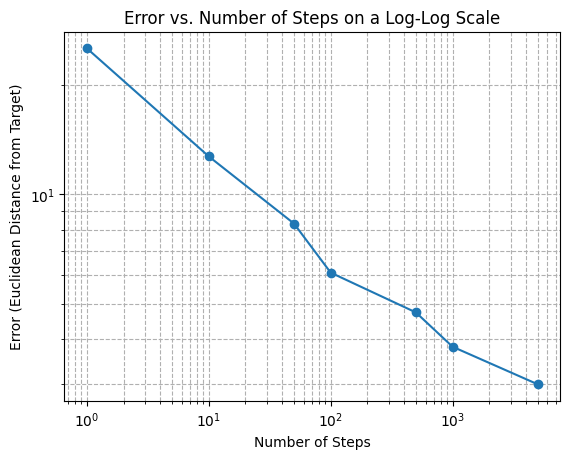

In [39]:
# OUR FIRST 1.2 BABY :D


# Compute the error
error=abs(exp_cost-value_func)
print(error) 
#Plot the error
plt.loglog(N_steps, error, marker='o', linestyle='-')
plt.xlabel('Number of Steps')
plt.ylabel('Error (Euclidean Distance from Target)')
plt.title('Error vs. Number of Steps on a Log-Log Scale')
plt.grid(True, which="both", ls="--")
plt.show()

Exercise 1.2.3

In [42]:
# 1.2.3 CODE DO NOT RUN IN GITHUB IF USING N_SAMPLES=100000

#N_samples=[10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000] #DO NOT RUN
N_samples = [10,50,100,250,500,750,1000]
N_steps = 5000
cost_samples = torch.tensor([])
exp_cost_samples = torch.tensor([])

# Time grid specifications
time_grid = torch.linspace(0, T, N_steps+1)
dt = time_grid[1:]-time_grid[:-1]
S_sol_cs_vals = torch.tensor((S_sol_cs(time_grid.numpy())),dtype=torch.float32)

for j in range(len(N_samples)):
    for i in range(N_samples[j]):
        result = generate_x(T, N_steps+1, H.float(), M.float(), D.float(), 
        S_sol_cs_vals.float(), sigma.float(), x0)

        alp = (-torch.inverse(D) @ M.T @ S_sol_cs_vals @result.transpose(1,2)).transpose(1,2)
        int_ = result@C@result.transpose(1,2) + alp@D@alp.transpose(1,2)

        J = result[-1]@R@result[-1].T + torch.tensor(0.5)*dt@((int_.squeeze(1)[1:]+int_.squeeze(1)[:-1]))
        cost_samples=torch.cat((cost_samples,J))
    
    exp_cost_samples=torch.cat((exp_cost_samples,torch.mean(cost_samples).unsqueeze(0)))

/tmp/ipykernel_3056/2947327018.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


tensor([5.1072, 5.1072, 5.1072, 5.1072, 5.1072, 5.1072, 5.1072])


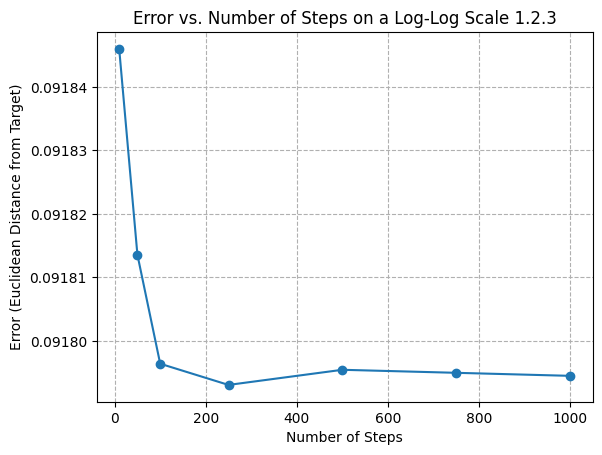

In [44]:
# OUR FIRST 1.2.3 BABY :D

print(exp_cost_samples) # why is the first one better than the second?

# Compute the error
error_samples = abs(exp_cost_samples-value_func)

#Plot the error
plt.plot(N_samples, error_samples, marker='o', linestyle='-')
plt.xlabel('Number of Steps')
plt.ylabel('Error (Euclidean Distance from Target)')
plt.title('Error vs. Number of Steps on a Log-Log Scale 1.2.3')
plt.grid(True, which="both", ls="--")
plt.show()

Exercise 2

In [5]:
# Function to generate training data
def generate_training_data(T, num_samples):
    # t = torch.tensor(np.random.uniform(0, T, num_samples), dtype=torch.float32)
    t = torch.linspace(0, T, num_samples)
    x = torch.tensor(np.random.uniform(-3, 3, (num_samples, 2)), dtype=torch.float32).unsqueeze(-1).transpose(1,2)
    return t, x

In [8]:
# Generate training data
T = 10
num_samples = 10
t_train, x_train = generate_training_data(T, num_samples)
t_train, x_train.shape

(tensor([ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
          8.8889, 10.0000]),
 torch.Size([10, 1, 2]))

In [9]:
print(lqr_system.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float())

tensor([[[1.0000, 0.0000],
         [0.0000, 1.0000]],

        [[1.0100, 0.0000],
         [0.0000, 1.0100]],

        [[1.0200, 0.0000],
         [0.0000, 1.0200]],

        ...,

        [[1.9995, 0.0000],
         [0.0000, 1.9995]],

        [[1.9995, 0.0000],
         [0.0000, 1.9995]],

        [[1.9995, 0.0000],
         [0.0000, 1.9995]]])


In [17]:
# Function to train the neural network
def train_net_dgm(net_dgm, t_train, x_train, epochs=1000, lr=0.001):
    optimizer = optim.Adam(net_dgm.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        v_pred = net_dgm(t_train.unsqueeze(1), x_train.squeeze(1))  # Predict value function
        loss = criterion(v_pred, lqr_system.value_function(t_train, x_train))  # Compute loss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

# Generate training data
T = 10
num_samples = 10
t_train, x_train = generate_training_data(T, num_samples)
lqr_system.value_function(t_train, x_train)

# Initialize the neural network
net_dgm = Net_DGM(dim_x=2, dim_S=100, hidden_size=100)

# Train the neural network
losses = train_net_dgm(net_dgm, t_train, x_train)

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


/home/codespace/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 154023.296875


KeyboardInterrupt: 

In [19]:
# Function to train the neural network
def train_ffn_net(net_ffn, t_train, x_train, epochs=1000, lr=0.001):
    optimizer = optim.Adam(net_ffn.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        a_pred = net_ffn(torch.cat((t_train.unsqueeze(1), x_train.squeeze(1)), dim=1))  # Predict markov control
        loss = loss = criterion(a_pred, lqr_system.markov_control(t_train, x_train))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

# Generate training data
T = 10
num_samples = 10
t_train, x_train = generate_training_data(T, num_samples)
print(lqr_system.markov_control(t_train, x_train))

# Define the sizes for the FFN network
sizes = [3, 100, 100, 2]  # Input size is 3 (time + 2 coordinates), 2 hidden layers of size 100, output size is 2

# Initialize the neural network
net_ffn = FFN(sizes)

# Train the neural network
losses = train_ffn_net(net_ffn, t_train, x_train)

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


tensor([[[-0.4739, -0.7655]],

        [[ 5.7272, -3.3154]],

        [[ 0.3340,  2.6193]],

        [[-5.5408, -0.7044]],

        [[-1.9877,  3.9947]],

        [[-2.7700, -4.3633]],

        [[ 3.6246,  3.3604]],

        [[ 3.6214, -5.3661]],

        [[-4.3558,  2.3364]],

        [[-4.5242,  0.4089]]])


/home/codespace/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10, 1, 2])) that is different to the input size (torch.Size([10, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 12.202160835266113


KeyboardInterrupt: 

Epoch 0, Loss: 1.5503544807434082


Epoch 100, Loss: -227.88821411132812
Epoch 200, Loss: -9006.6044921875
Epoch 300, Loss: -86303.328125
Epoch 400, Loss: -309862.34375
Epoch 500, Loss: -697840.5625
Epoch 600, Loss: -1276609.625
Epoch 700, Loss: -2086489.625
Epoch 800, Loss: -3166224.0
Epoch 900, Loss: -4567983.0
None


ValueError: x, y, and format string must not be None

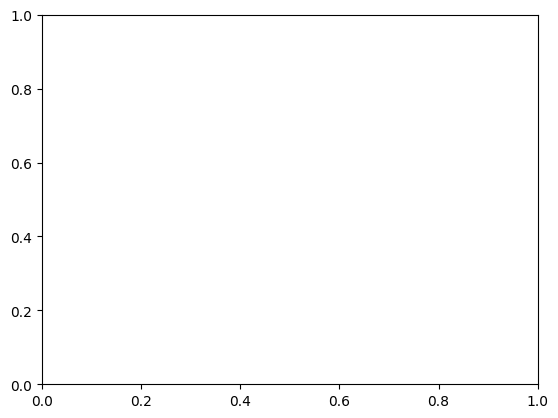

In [48]:
class PDE():
    def __init__(self, net, T, sigma, H, M, C, D, R, alpha):
        self.net = net
        self.T = T
        self.sigma = sigma
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.alpha = alpha
    
    def pde_residual(self, t, x):
        t.requires_grad_(True)
        x.requires_grad_(True)
        
        u = self.net(t, x)  
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # Compute the trace term
        trace_term = 0.5 * torch.trace(torch.matmul(self.sigma, self.sigma.T)) * u_xx.sum(dim=1, keepdim=True)  # (batch, 2)
        t1 = (u_x @ self.H @ x.T).sum(dim=1).unsqueeze(1)
        t2 = (torch.matmul(u_x, torch.matmul(self.M, self.alpha.T))).T.unsqueeze(1)
        t3 = (torch.matmul(x, torch.matmul(self.C, x.T)).sum(dim=1)).unsqueeze(1)
        scalar_value = torch.matmul(self.alpha.T, torch.matmul(self.D, self.alpha))
        t4 = scalar_value.unsqueeze(0).unsqueeze(1).repeat(num_samples, 1)

        # Compute the PDE residual term
        pde_res = (
            u_t + trace_term + t1 + t2 + t3 + t4
        )

        return pde_res

    def boundary_condition(self, x):
        # Compute the boundary condition term
        t = torch.full_like(x[:, :1], self.T.item())  # Create a tensor of the same size as x with values T
        u = self.net(t, x)  # Neural network output at the final time
        boundary_term = torch.square(u - torch.matmul(x, self.R))
        return boundary_term

class DGM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGM, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Tanh()

    def forward(self, t, x):
        input_tensor = torch.cat((t, x), dim=1)
        hidden1 = self.activation(self.fc1(input_tensor))
        hidden2 = self.activation(self.fc2(hidden1))
        output = self.fc3(hidden2)
        return output

def loss_function(u, t, x, linear_pde):
    pde_residual = linear_pde.pde_residual(t, x)
    boundary_term = linear_pde.boundary_condition(x)
    loss = pde_residual.mean() + boundary_term.mean()  # Compute the mean loss
    return loss

def train_dgm(model, t_train, x_train, linear_pde, epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        u_pred = model(t_train, x_train)
        loss = loss_function(u_pred, t_train, x_train, linear_pde)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())  # Store the loss value
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Define hyperparameters
input_dim = 3  # Input dimension (time, space_x, space_y)
hidden_dim = 100  # Hidden layer dimension
output_dim = 1  # Output dimension (solution)
num_samples = 10  # Number of training samples
T = torch.tensor([1], dtype=torch.float32)  # End time
epochs = 1000  # Number of training epochs
lr = 0.001  # Learning rate
alpha = torch.tensor([1.0, 1.0], dtype=torch.float32)

# Initialize the DGM model
model = DGM(input_dim, hidden_dim, output_dim)

# Create an instance of the HeatEquation2D class
linear_pde = PDE(model, T, sigma, H, M, C, D, R, alpha)

# Generate training data
t_train = torch.rand(num_samples, 1) * T
x_train = torch.rand(num_samples, 2)  # Assuming 2D space

# Train the DGM model
losses = train_dgm(model, t_train, x_train, linear_pde, epochs, lr)

# Plot the losses
plt.plot(range(epochs), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()
